In [2]:
from roboflow import Roboflow

In [3]:
!mkdir {HOME}/datasets
%cd {HOME}/datsets

rf = Roboflow(api_key="Your_API_Key")
project = rf.workspace("license-plate-sf8t4").project("license-plate-detection-g15hx-hofxb")
version = project.version(1)
dataset = version.download("coco")


mkdir: cannot create directory ‘{HOME}/datasets’: No such file or directory
[Errno 2] No such file or directory: '{HOME}/datsets'
/content
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to license-plate-detection-1 in coco:: 100%|██████████| 5411/5411 [00:02<00:00, 2574.56it/s]


In [4]:
dataset.location

'/content/license-plate-detection-1'

In [5]:
from transformers import DetrImageProcessor

In [6]:
image_processor = DetrImageProcessor.from_pretrained('facebook/detr-resnet-50')


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

In [7]:
import os
import torchvision

In [8]:
###Create a coco data loader pipeline
annotation_file = "_annotations.coco.json"
train_dir = os.path.join(dataset.location, 'train')
val_dir = os.path.join(dataset.location, 'valid')
test_dir = os.path.join(dataset.location, 'test')

In [9]:
from PIL import Image

In [10]:
class CocoDetection(torchvision.datasets.CocoDetection):
  def __init__( self, image_directory_path: str, image_processor, train: bool =True):
    annotation_file_path = os.path.join(image_directory_path, annotation_file)
    super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
    self.image_processor = image_processor

  def __getitem__(self, idx):
    images, annotations = super(CocoDetection, self).__getitem__(idx)
    image_id = self.ids[idx]
    annotations = {'image_id': image_id, 'annotations': annotations}
    encoding = self.image_processor(images=images, annotations=annotations, return_tensors='pt')
    pixel_values = encoding['pixel_values'].squeeze()
    target = encoding['labels'][0]
    return pixel_values, target


In [11]:
train_data = CocoDetection(
    image_directory_path = train_dir,
    image_processor = image_processor,
    train=True)

val_data = CocoDetection(
    image_directory_path=val_dir,
    image_processor = image_processor,
    train=False
)

test_data = CocoDetection(
    image_directory_path=test_dir,
    image_processor=image_processor,
    train=False
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [12]:
print("No. of training image", len(train_data))
print("No. validation image", len(val_data))
print("No. test image", len(val_data))

No. of training image 4962
No. validation image 220
No. test image 220


In [13]:
import random
import cv2
import numpy as np
import supervision as sv

In [14]:
img_id = train_data.coco.getImgIds()
image_id = random.choice(img_id)

In [15]:
image = train_data.coco.loadImgs(image_id)[0]
annotations = train_data.coco.imgToAnns[image_id]
img_path = os.path.join(train_data.root, image['file_name'])
image = cv2.imread(img_path)

In [16]:
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

In [17]:
categories = train_data.coco.cats
id_to_category = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id_to_category[class_id]}"
    for _, _, class_id, _
    in detections
]

In [18]:
box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

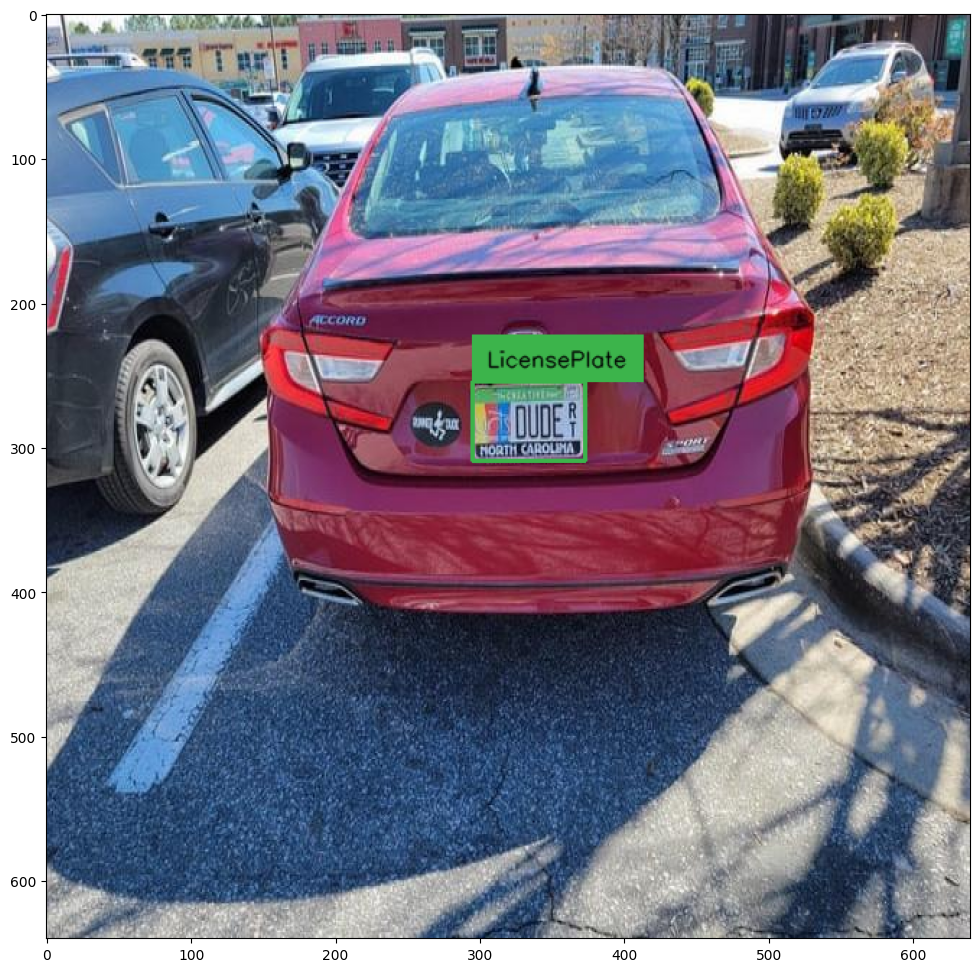

In [19]:
%matplotlib inline
sv.show_frame_in_notebook(frame, (12,12))


In [20]:
from torch.utils.data import DataLoader
from torchvision import transforms
import torch

In [21]:
def batch_loader(batch): #collate function
  pixel_values = [items[0] for items in batch]
  encoding = image_processor.pad(pixel_values, return_tensors='pt')
  labels = [item[1] for item in batch]
  return {
      'pixel_values': encoding['pixel_values'],
      'pixel_mask': encoding['pixel_mask'],
      'labels': labels
  }

In [22]:
train_dataloader = DataLoader(dataset=train_data, collate_fn=batch_loader, batch_size=2, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, collate_fn=batch_loader, batch_size=2)
test_dataloader = DataLoader(dataset=test_data, collate_fn=batch_loader, batch_size=2)

In [23]:
##Train model with PyTorch Lightning
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

In [24]:
CHECKPOINT = "facebook/detr-resnet-50"

In [25]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [26]:
class DTRTrainer(pl.LightningModule):
  def __init__(self, lr, lr_backbone, weight_decay):
    super().__init__()
    self.model = DetrForObjectDetection.from_pretrained(
        pretrained_model_name_or_path=CHECKPOINT,
        num_labels=len(id_to_category),
        ignore_mismatched_sizes=True
    )
    self.lr = lr
    self.lr_backbone = lr_backbone
    self.weight_decay = weight_decay

  def forward(self, pixel_values, pixel_mask):
    return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

  def common_step(self, batch, batch_idx):
    pixel_values = batch['pixel_values']
    pixel_mask = batch['pixel_mask']
    labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch['labels']]

    #forward pass
    outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
    loss = outputs.loss
    loss_dict = outputs.loss_dict
    return loss, loss_dict


    # Forward pass
    outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
    loss = outputs.loss
    loss_dict = outputs.loss_dict
    return loss, loss_dict


  def training_step(self, batch, batch_idx):
    loss, loss_dict = self.common_step(batch, batch_idx)
    self.log("training_loss", loss)
    for k,v in loss_dict.items():
      self.log('train_' + k, v.item())
    return loss

  def validation_step(self, batch, batch_idx):
    loss, loss_dict = self.common_step(batch, batch_idx)
    self.log("validation/loss", loss)
    for k, v in loss_dict.items():
      self.log("validation_" + k, v.item())
    return loss

  def configure_optimizers(self):
    param_dict=[{
              'params': [p for n, p in self.named_parameters() if 'backbone' not in n and p.requires_grad]},
          {
              'params': [p for n, p in self.named_parameters() if 'backbone' in n and p.requires_grad],
              'lr':self.lr_backbone

              },

      ]
    return torch.optim.AdamW(param_dict, lr=self.lr, weight_decay=self.weight_decay)

  def train_dataloader(self):
    return train_dataloader

  def val_dataloader(self):
    return val_dataloader

In [27]:
'''#lunch tensor board
%cd {HOME}
%load_ext tensorboard
%tensorboard --logdir lightning_logs/
'''

'#lunch tensor board\n%cd {HOME}\n%load_ext tensorboard\n%tensorboard --logdir lightning_logs/\n'

In [28]:
model = DTRTrainer(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [29]:
batch = next(iter(train_dataloader))
print("Pixel values shape:", batch['pixel_values'].shape)
print("Labels:", batch['labels'])


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Pixel values shape: torch.Size([2, 3, 800, 800])
Labels: [{'size': tensor([800, 800]), 'image_id': tensor([4438]), 'class_labels': tensor([1]), 'boxes': tensor([[0.4250, 0.5570, 0.2406, 0.2828]]), 'area': tensor([43553.1250]), 'iscrowd': tensor([0]), 'orig_size': tensor([640, 640])}, {'size': tensor([800, 800]), 'image_id': tensor([2394]), 'class_labels': tensor([1]), 'boxes': tensor([[0.5273, 0.4992, 0.8766, 0.8953]]), 'area': tensor([502270.3125]), 'iscrowd': tensor([0]), 'orig_size': tensor([640, 640])}]


In [30]:
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [31]:
outputs.logits.shape

torch.Size([2, 100, 3])

In [32]:
from pytorch_lightning import Trainer

In [34]:
%cd {HOME}

epoch = 10

train = Trainer(devices=1, accelerator="gpu", max_epochs=epoch, gradient_clip_val=0.1, accumulate_grad_batches=4,
                log_every_n_steps=2)
train.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


[Errno 2] No such file or directory: '{HOME}'
/content


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                   | Params | Mode
--------------------------------------------------------
0 | model | DetrForObjectDetection | 41.5 M | eval
--------------------------------------------------------
41.3 M    Trainable params
222 K     Non-trainable params
41.5 M    Total params
166.008   Total estimated model params size (MB)
0         Modules in train mode
399       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [43]:
model.to(DEVICE)

DTRTrainer(
  (model): DetrForObjectDetection(
    (model): DetrModel(
      (backbone): DetrConvModel(
        (conv_encoder): DetrConvEncoder(
          (model): FeatureListNet(
            (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            (bn1): DetrFrozenBatchNorm2d()
            (act1): ReLU(inplace=True)
            (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            (layer1): Sequential(
              (0): Bottleneck(
                (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (bn1): DetrFrozenBatchNorm2d()
                (act1): ReLU(inplace=True)
                (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (bn2): DetrFrozenBatchNorm2d()
                (drop_block): Identity()
                (act2): ReLU(inplace=True)
                (aa): Identity()
                (conv3): Conv2d(6

In [44]:
cat = test_data.coco.cats
id_to_lables = {k: v['name'] for k, v in cat.items()}
box_annot = sv.BoxAnnotator()

In [98]:
img_ids = test_data.coco.getImgIds()
img_id = random.choice(img_ids)
print("Image {}".format(img_id))

Image 200


In [99]:
img = test_data.coco.loadImgs(img_id)[0]
annot = test_data.coco.imgToAnns[img_id]
img_path = os.path.join(test_data.root, img['file_name'])
img = cv2.imread(img_path)

In [100]:
detection = sv.Detections.from_coco_annotations(coco_annotation=annot)
labels = [f"{id_to_lables[class_id]}" for _, _, class_id, _ in detection]
frame = box_annotator.annotate(scene=img.copy(), detections=detection, labels=labels)

Real Image


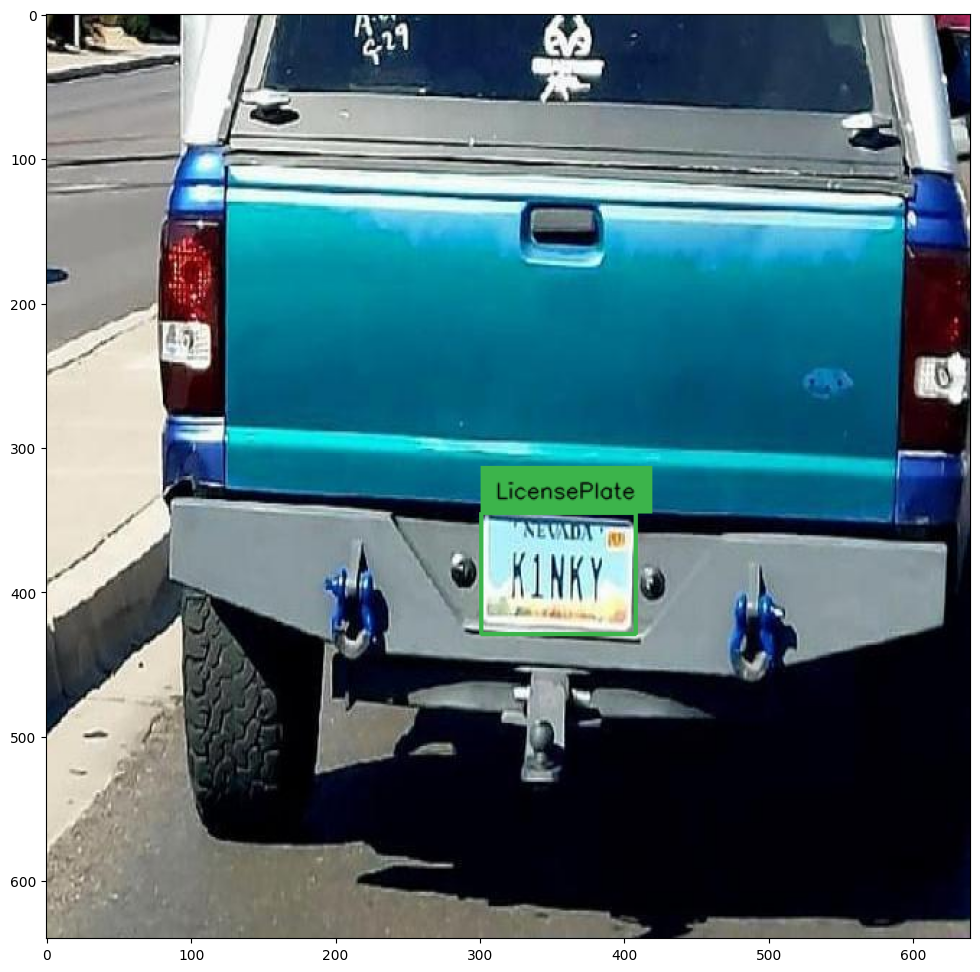

In [101]:
print('Real Image')
%matplotlib inline
sv.show_frame_in_notebook(frame, (12,12))

In [102]:
CONFIDENCE_THRESHOLD =  0.5

In [103]:
with torch.no_grad():
  input = image_processor(images=img, return_tensors='pt').to(DEVICE)
  outputs = model(**input)

  target_size = torch.tensor([img.shape[:2]]).to(DEVICE)
  results = image_processor.post_process_object_detection(outputs=outputs, threshold=CONFIDENCE_THRESHOLD, target_sizes=target_size)[0]

In [104]:
 results

{'scores': tensor([0.9983], device='cuda:0'),
 'labels': tensor([1], device='cuda:0'),
 'boxes': tensor([[299.0808, 346.5477, 408.5260, 429.7034]], device='cuda:0')}

In [105]:
detections = sv.Detections.from_transformers(transformers_results=results)

Detected Objects


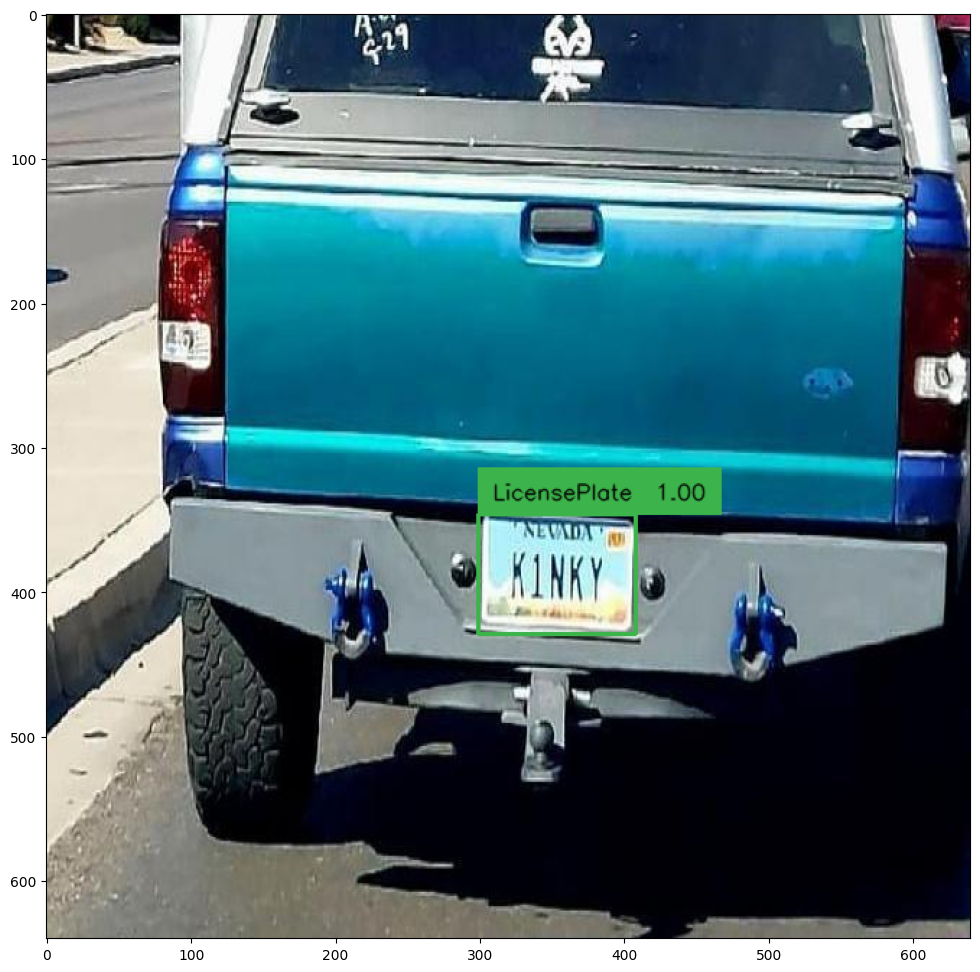

In [106]:
labels = [f"{id_to_lables[class_id]} {confidence: .2f}" for _, confidence, class_id, _ in detections]
frame = box_annot.annotate(scene=img.copy(), detections=detections, labels=labels)

print("Detected Objects")
%matplotlib inline
sv.show_frame_in_notebook(frame, (12,12))

In [95]:
##Saving model
model.model.save_pretrained('/content/trained_model')

In [97]:
##Loading model
model1 = DetrForObjectDetection.from_pretrained('/content/trained_model')
model1.to(DEVICE)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

**Downloading trained model to the local computer**

In [ ]:
import shutil
from google.colab import files

In [107]:
# Zip the folder
shutil.make_archive('/content/trained_model', 'zip', '/content/trained_model')

# Download the zipped folder
files.download('/content/trained_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>